# PyVISA
## Env & Func
Actually, we should use the PyVISA package to control the KeySight VNA Device


In [1]:
import pyvisa as visa

# rm = pyvisa.ResourceManager()

# VNA Control Class
class VNAController:
    """A class to control a KeySight USB VNA using PyVISA."""
    
    # Initialize the VISA Resource Manager and session
    def __init__(self):
        self.rm = visa.ResourceManager()
        self.session = None

    def list_devices(self):
        """List all connected VISA devices."""
        return self.rm.list_resources()

    def open_device(self, resource_name):
        """Open a VISA device."""
        try:
            self.session = self.rm.open_resource(resource_name)
            return self.session
        except visa.VisaIOError as e:
            print(f"Error opening device {resource_name}: {e}")
            return None

    def close_device(self):
        """Close the opened VISA device."""
        if self.session:
            try:
                self.session.close()
            except visa.VisaIOError as e:
                print(f"Error closing device: {e}")
            finally:
                self.session = None

    def query(self, command):
        """Send a command to the device and return the response."""
        if not self.session:
            print("No device session is open.")
            return None
        try:
            response = self.session.query(command)
            return response
        except visa.VisaIOError as e:
            print(f"Error querying device: {e}")
            return None

## Test

In [2]:
# Main Code: Device Connection Test
if __name__ == "__main__":
    vna_controller = VNAController()
    
    # List connected devices
    devices = vna_controller.list_devices()
    print("Connected VISA devices:", devices)
    
    # Open a device (replace 'USB0::0x0957::0x0607::MY12345678::INSTR' with your device's resource name)
    if devices:
        device = vna_controller.open_device(devices[0])
        if device:
            print(f"Device {device} opened successfully.")
            # Perform operations with the device here
            device.timeout = 20000
            print("Querying device for IDN...")
            print(vna_controller.query("*IDN?"))  # Query the device ID

            # Close the device after operations
            vna_controller.close_device()
            print("Device closed successfully.")
    else:
        print("No VISA devices found.")



Connected VISA devices: ('PXI0::9-0.0::INSTR',)
Device PXIInstrument at PXI0::9-0.0::INSTR opened successfully.
Querying device for IDN...


AttributeError: 'PXIInstrument' object has no attribute 'query'

# Access the data from the instrument directly

[DEBUG] VISA资源管理器初始化成功
[DEBUG] 发现设备: ('PXI0::9-0.0::INSTR', 'TCPIP0::MagicbookPro16-Hunter::hislip_PXI0_CHASSIS1_SLOT1_INDEX0::INSTR')
[DEBUG] 正在打开设备: TCPIP0::MagicbookPro16-Hunter::hislip_PXI0_CHASSIS1_SLOT1_INDEX0::INSTR
[DEBUG] 设备ID: Keysight Technologies,P9371B,MY61100600,A.19.30.21
[DEBUG] 开始读取A-Scan时域数据...
[DEBUG] 读取A-Scan时域数据完成，耗时: 0.040秒, 数据点: 501
[DEBUG] 
A-Scan数据信息:
[DEBUG] 数据长度: 501
[DEBUG] 数据类型: float64
[DEBUG] 有效数据范围: -0.004045 到 0.005760
[DEBUG] 
前10个数据点:
[DEBUG]  1: 0.000021
[DEBUG]  2: -0.000022
[DEBUG]  3: 0.000267
[DEBUG]  4: 0.000912
[DEBUG]  5: 0.000325
[DEBUG]  6: -0.002401
[DEBUG]  7: -0.004045
[DEBUG]  8: -0.000717
[DEBUG]  9: 0.004910
[DEBUG] 10: 0.005760
[DEBUG] 
加载参考数据文件: c:\Users\unive\Desktop\CDUT_UavGPR_Controller_v202511\tests\从P9371B导出保存的一道A-Scan参考数据.csv
[DEBUG] 参考数据加载完成，数据点数量: 501
[DEBUG] 
=== A-Scan数据验证结果 ===
[DEBUG] 读取到的数据点: 501
[DEBUG] 参考数据点: 501
[DEBUG] 期望数据点: 501
[DEBUG] 时间范围: 0-900ns
[DEBUG] 数据点数量匹配: 是
[DEBUG] 期望数量匹配: 是
[DEBUG] 数据相关性: 0.9999
[DEBUG

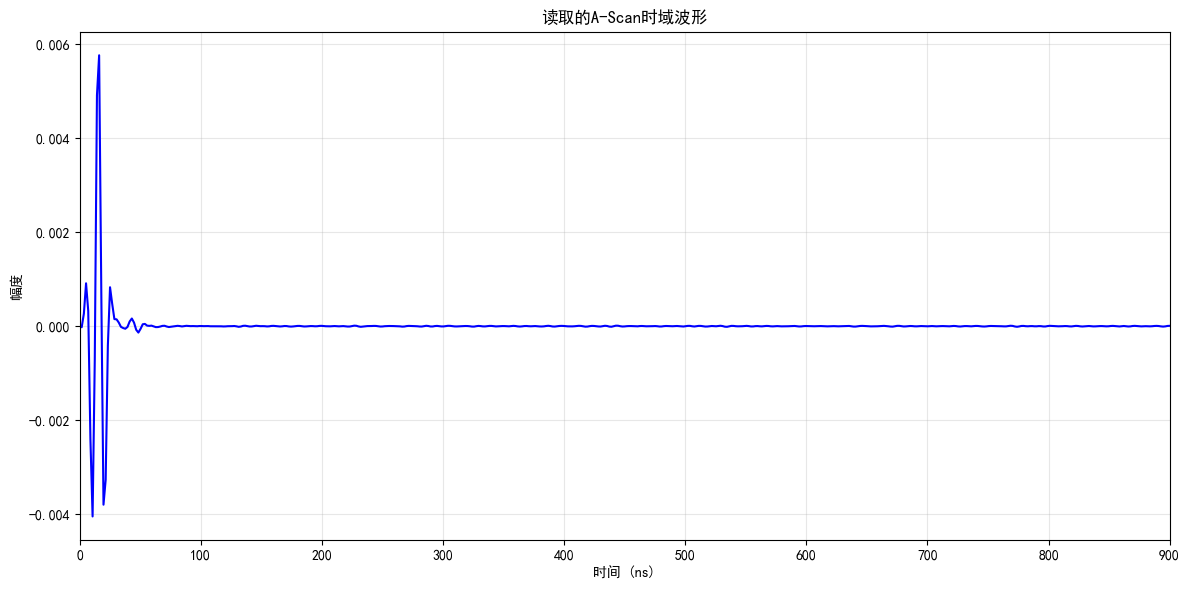

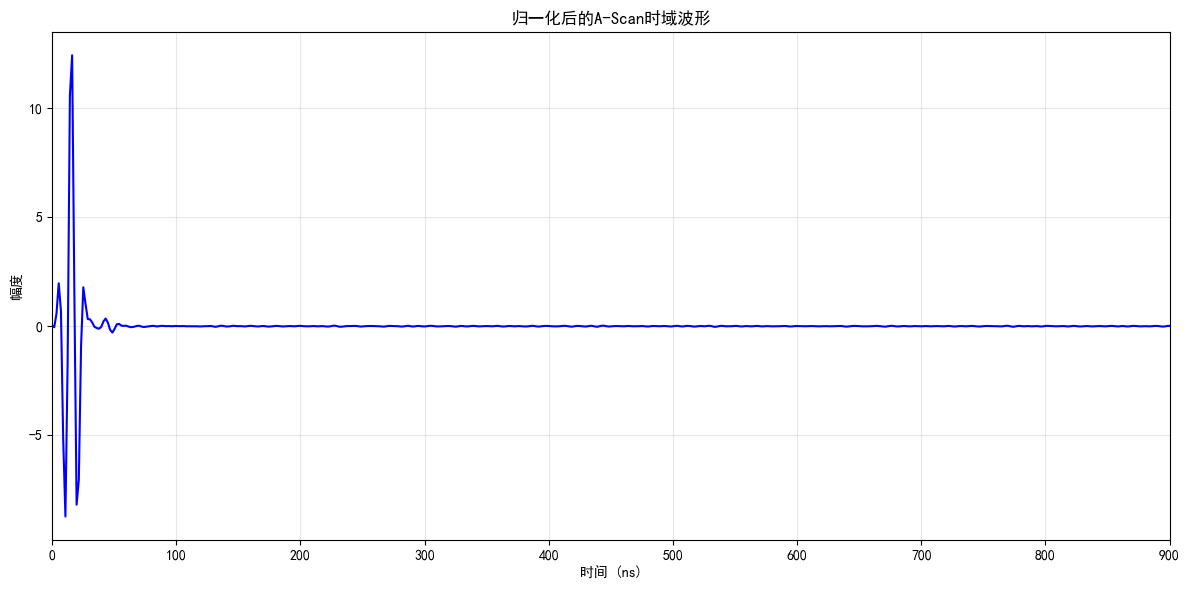

[DEBUG] 设备已关闭
[DEBUG] 程序已退出


In [2]:
# 直接获取数据而不是CSV文件存储的方式测试
#!/usr/bin/env python
# coding: utf-8

# 矢网仪A-Scan时域波形读取测试
# 本示例展示如何使用SCPI指令直接读取VNA显示的时域A-Scan数据，并绘制验证

# 导入必要的库
import pyvisa as visa
import numpy as np
import matplotlib.pyplot as plt
import time
import csv

# 配置matplotlib支持中文显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

DEBUG = True
def debug_print(*args, **kwargs):
    if DEBUG:
        print("[DEBUG]", *args, **kwargs)


# ## 1. 矢网仪控制器类


class SimpleVNAController:
    """
    简化版矢网仪控制器类，仅用于读取A-Scan时域数据
    """
    def __init__(self):
        self.rm = None
        self.vna = None
        self.current_channel = 1
        self.current_measurement = 1
        
        try:
            self.rm = visa.ResourceManager()
            debug_print("VISA资源管理器初始化成功")
        except Exception as e:
            debug_print(f"VISA资源管理器初始化失败: {e}")
            self.rm = None

    def list_devices(self):
        """列出所有连接的VISA设备"""
        if not self.rm:
            debug_print("资源管理器未初始化")
            return []
        try:
            resources = self.rm.list_resources()
            debug_print(f"发现设备: {resources}")
            return resources
        except Exception as e:
            debug_print(f"列出设备失败: {e}")
            return []

    def open_device(self, resource_name, timeout=30000):
        """打开VISA设备"""
        if not self.rm:
            debug_print("资源管理器未初始化")
            return False
        
        try:
            debug_print(f"正在打开设备: {resource_name}")
            self.close_device()  # 确保之前的连接已关闭
            self.vna = self.rm.open_resource(resource_name)
            self.vna.timeout = timeout  # 增加超时时间到30秒
            self.vna.write_termination = '\n'
            self.vna.read_termination = '\n'
            
            # 检查设备ID
            idn = self.query("*IDN?")
            debug_print(f"设备ID: {idn}")
            
            # 设置数据格式为二进制
            self.write("FORM:DATA REAL,32")  # 32位浮点数
            self.write("FORM:BORD NORM")     # 正常字节顺序
            
            return True
        except Exception as e:
            debug_print(f"打开设备失败: {e}")
            self.vna = None
            return False

    def close_device(self):
        """关闭VISA设备"""
        if self.vna:
            try:
                self.vna.close()
                debug_print("设备已关闭")
            except Exception as e:
                debug_print(f"关闭设备失败: {e}")
            finally:
                self.vna = None

    def write(self, command):
        """发送命令到设备"""
        if not self.vna:
            debug_print("设备未连接")
            return False
        try:
            self.vna.write(command)
            return True
        except Exception as e:
            debug_print(f"发送命令失败: {e}")
            return False

    def query(self, command):
        """发送查询命令并返回响应"""
        if not self.vna:
            debug_print("设备未连接")
            return None
        try:
            return self.vna.query(command).strip()
        except Exception as e:
            debug_print(f"查询失败: {e}")
            return None

    def read_ascan_data(self):
        """直接读取VNA显示的A-Scan时域数据
        使用CALC:MEAS:DATA:FDATA?获取显示的时域数据
        采用ASCII格式以确保可靠的数据解析
        """
        if not self.vna:
            debug_print("设备未连接")
            return None
        
        try:
            # 设置数据格式为ASCII
            self.write("FORM:DATA ASCII")
            
            # 使用FDATA获取显示的时域数据
            start_time = time.time()
            command = f"CALC{self.current_channel}:MEAS{self.current_measurement}:DATA:FDATA?"
            ascii_data = self.query(command)
            read_time = time.time() - start_time
            
            # 解析ASCII数据
            if ascii_data:
                # 分割数据并转换为浮点数
                data_points = ascii_data.split(',')
                float_data = [float(point) for point in data_points if point.strip()]
                np_data = np.array(float_data)
                
                debug_print(f"读取A-Scan时域数据完成，耗时: {read_time:.3f}秒, 数据点: {len(np_data)}")
                return np_data
            
            return None
        except Exception as e:
            debug_print(f"读取A-Scan数据失败: {e}")
            return None


# ## 2. 数据可视化工具
class SimpleVisualizer:
    """
    简化版数据可视化类，仅提供A-Scan时域波形绘制功能
    """
    @staticmethod
    def plot_ascan_time_domain(data, time_range_ns=900, title='A-Scan时域波形'):
        """绘制A-Scan时域波形
        参数：
        - data: A-Scan数据数组
        - time_range_ns: 时间范围（纳秒），默认900ns
        - title: 图像标题
        """
        # 创建时间数组，从0到time_range_ns均匀分布
        time_array = np.linspace(0, time_range_ns, len(data))
        
        # 创建画布，绘制时域波形
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # 时域波形图
        ax.plot(time_array, data, 'b-', linewidth=1.5)
        ax.set_xlabel('时间 (ns)')
        ax.set_ylabel('幅度')
        ax.set_title(title)
        ax.grid(True, alpha=0.3)
        
        # 设置X轴范围
        ax.set_xlim(0, time_range_ns)
        
        plt.tight_layout()
        plt.show()


# ## 3. 数据验证工具


class DataValidator:
    """
    数据验证类，用于验证读取到的A-Scan数据是否与参考数据一致
    """
    @staticmethod
    def load_reference_data(file_path):
        """加载参考CSV数据
        参数：
        - file_path: 参考数据文件路径
        返回：
        - time_data: 时间数组（ns）
        - amp_data: 幅度数据数组
        """
        time_data = []
        amp_data = []
        
        with open(file_path, 'r', encoding='utf-8') as f:
            reader = csv.reader(f)
            # 跳过前7行标题和元数据
            for _ in range(7):
                next(reader)
            # 读取数据行
            for row in reader:
                if len(row) >= 2 and row[0] != 'END':
                    try:
                        # 时间转换为纳秒
                        time_ns = float(row[0]) * 1e9
                        amp = float(row[1])
                        time_data.append(time_ns)
                        amp_data.append(amp)
                    except ValueError:
                        continue
        
        return np.array(time_data), np.array(amp_data)
    
    @staticmethod
    def validate_data(ascan_data, reference_time, reference_amp):
        """验证A-Scan数据
        参数：
        - ascan_data: 读取到的A-Scan数据
        - reference_time: 参考时间数组
        - reference_amp: 参考幅度数组
        返回：
        - 验证结果字典
        """
        result = {
            "read_data_points": len(ascan_data),
            "ref_data_points": len(reference_amp),
            "time_range": "0-900ns",
            "expected_points": 501,
            "points_match": len(ascan_data) == len(reference_amp),
            "range_match": len(ascan_data) == 501
        }
        
        # 计算数据相关性
        if len(ascan_data) == len(reference_amp):
            # 归一化数据
            ascan_norm = (ascan_data - np.mean(ascan_data)) / np.std(ascan_data)
            ref_norm = (reference_amp - np.mean(reference_amp)) / np.std(reference_amp)
            correlation = np.corrcoef(ascan_norm, ref_norm)[0, 1]
            result["correlation"] = correlation
            result["high_correlation"] = abs(correlation) > 0.5
        else:
            result["correlation"] = None
            result["high_correlation"] = False
        
        return result
    
    @staticmethod
    def print_validation_result(result):
        """打印验证结果"""
        debug_print("\n=== A-Scan数据验证结果 ===")
        debug_print(f"读取到的数据点: {result['read_data_points']}")
        debug_print(f"参考数据点: {result['ref_data_points']}")
        debug_print(f"期望数据点: {result['expected_points']}")
        debug_print(f"时间范围: {result['time_range']}")
        debug_print(f"数据点数量匹配: {'是' if result['points_match'] else '否'}")
        debug_print(f"期望数量匹配: {'是' if result['range_match'] else '否'}")
        
        if result['correlation'] is not None:
            debug_print(f"数据相关性: {result['correlation']:.4f}")
            debug_print(f"高相关性: {'是' if result['high_correlation'] else '否'}")
        
        debug_print("=== 验证结束 ===")


# ## 4. 主程序


def main():
    # 创建控制器实例
    vna_controller = SimpleVNAController()
    
    try:
        # 1. 列出设备
        devices = vna_controller.list_devices()
        if not devices:
            debug_print("未找到任何设备")
            return
        
        # 2. 选择设备连接
        # 使用用户提供的设备名称
        device_name = "TCPIP0::MagicbookPro16-Hunter::hislip_PXI0_CHASSIS1_SLOT1_INDEX0::INSTR"
        if not vna_controller.open_device(device_name):
            debug_print("无法打开设备")
            return
        
        # 3. 读取A-Scan时域数据
        debug_print("开始读取A-Scan时域数据...")
        ascan_data = vna_controller.read_ascan_data()
        if ascan_data is None:
            return
        
        # 4. 终端打印数据信息
        debug_print("\nA-Scan数据信息:")
        debug_print(f"数据长度: {len(ascan_data)}")
        debug_print(f"数据类型: {ascan_data.dtype}")
        
        # 计算有效的数据范围（排除极端值）
        valid_data = ascan_data[np.isfinite(ascan_data)]
        if len(valid_data) > 0:
            debug_print(f"有效数据范围: {valid_data.min():.6f} 到 {valid_data.max():.6f}")
        else:
            debug_print(f"数据范围: {ascan_data.min():.6f} 到 {ascan_data.max():.6f}")
        
        # 打印前10个数据点
        debug_print("\n前10个数据点:")
        for i in range(min(10, len(ascan_data))):
            debug_print(f"{i+1:2d}: {ascan_data[i]:.6f}")
        
        # 5. 验证数据与参考CSV文件的一致性
        ref_file = "c:\\Users\\unive\\Desktop\\CDUT_UavGPR_Controller_v202511\\tests\\从P9371B导出保存的一道A-Scan参考数据.csv"
        debug_print(f"\n加载参考数据文件: {ref_file}")
        ref_time, ref_amp = DataValidator.load_reference_data(ref_file)
        debug_print(f"参考数据加载完成，数据点数量: {len(ref_amp)}")
        
        # 验证数据
        validation_result = DataValidator.validate_data(ascan_data, ref_time, ref_amp)
        DataValidator.print_validation_result(validation_result)
        
        # 6. 绘制A-Scan时域波形
        debug_print("\n绘制A-Scan时域波形...")
        SimpleVisualizer.plot_ascan_time_domain(ascan_data, time_range_ns=900, title='读取的A-Scan时域波形')
        # 绘制一下归一化（Z-score标准化）后的A-Scan数据
        ascan_norm = (ascan_data - np.mean(ascan_data)) / np.std(ascan_data)
        SimpleVisualizer.plot_ascan_time_domain(ascan_norm, time_range_ns=900, title='归一化后的A-Scan时域波形')

    except KeyboardInterrupt:
        debug_print("\n用户中断程序")
    except Exception as e:
        debug_print(f"程序错误: {e}")
    finally:
        # 清理资源
        vna_controller.close_device()
        plt.close('all')
        debug_print("程序已退出")

# 运行主程序
if __name__ == "__main__":
    main()